In [1]:
import numpy as np
from keras.datasets import mnist

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

## Display the images

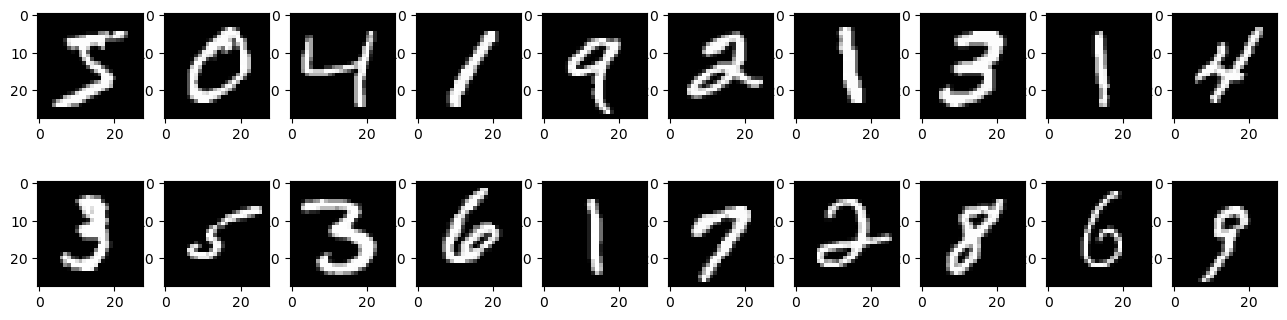

In [3]:
from matplotlib import pyplot as plt

def plot_train_data(train):
    fig, axes = plt.subplots(2, 10, figsize=(16, 4))

    count = 0

    for i in range(2):
        for ix in range(10):
            axes[i, ix].imshow(train[count], cmap='gray')
            count += 1
            
plot_train_data(X_train)

## Normalize the images

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Add noise to images

In [5]:
# prepare source data
noise_factor = 0.1
X_train_noise = X_train + noise_factor * np.random.normal(loc=0, scale=1., size=X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc=0, scale=1., size=X_test.shape)

## Display noisy data

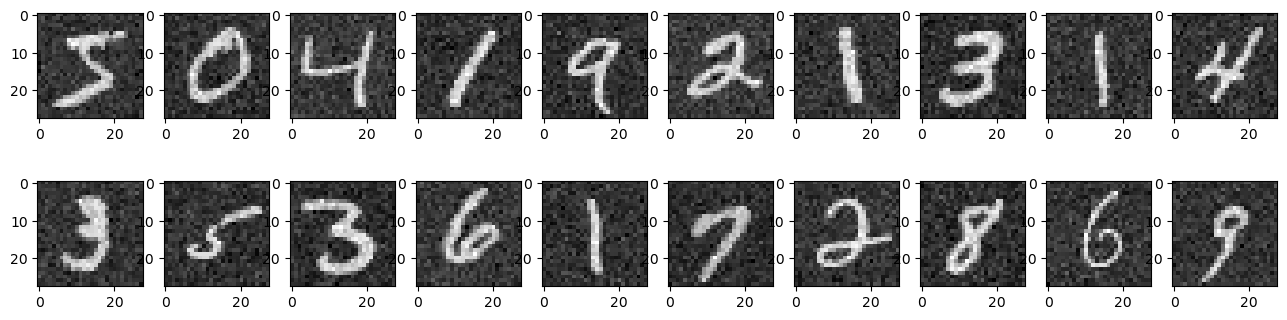

In [6]:
plot_train_data(X_train_noise)

## Reshape dataset into 3D cause we need to??

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 28, 28, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 28, 28, 1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

## Create the model

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

In [12]:
# this doesn't work on tensorflow > 2.10 on windows.
# devices = tf.config.experimental.list_physical_devices("GPU")
# devices
# #tf.config.experimental.set_memory_growth(devices[0], enable=True)

## Create Encoder

In [13]:
encoder_input = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size=(2, 2), padding='same')(x)

## Create Decoder

In [14]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [20]:
autoencoder = Model(encoder_input, decoded, name='Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,865 (112.75 KB)

 Trainable params: 28,609 (111.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [21]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## Train the model

In [22]:
checkpoint = ModelCheckpoint('denoising_model.keras', save_best_only=True, save_weights_only=False, verbose=1)
history = autoencoder.fit(X_train_noise, X_train, batch_size=128, epochs=50, callbacks=checkpoint, validation_split=0.25, verbose=2)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.11068, saving model to denoising_model.keras
352/352 - 8s - 23ms/step - loss: 0.1598 - val_loss: 0.1107
Epoch 2/50

Epoch 2: val_loss improved from 0.11068 to 0.07504, saving model to denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0756 - val_loss: 0.0750
Epoch 3/50

Epoch 3: val_loss did not improve from 0.07504
352/352 - 6s - 18ms/step - loss: 0.0730 - val_loss: 0.0786
Epoch 4/50

Epoch 4: val_loss improved from 0.07504 to 0.07216, saving model to denoising_model.keras
352/352 - 7s - 19ms/step - loss: 0.0717 - val_loss: 0.0722
Epoch 5/50

Epoch 5: val_loss did not improve from 0.07216
352/352 - 7s - 19ms/step - loss: 0.0708 - val_loss: 0.0729
Epoch 6/50

Epoch 6: val_loss improved from 0.07216 to 0.07047, saving model to denoising_model.keras
352/352 - 6s - 18ms/step - loss: 0.0704 - val_loss: 0.0705
Epoch 7/50

Epoch 7: val_loss did not improve from 0.07047
352/352 - 7s - 18ms/step - loss: 0.0699 - val_loss: 0.0706
Epoch 

## Load best model

In [23]:
from keras.models import load_model
autoencoder = load_model('denoising_model.keras')
autoencoder.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,085 (336.27 KB)

 Trainable params: 28,609 (111.75 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 57,220 (223.52 KB)

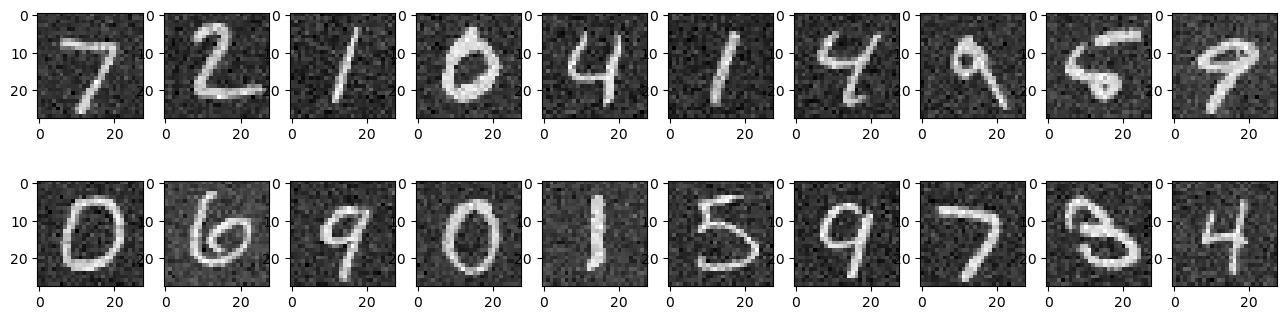

In [24]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28, 28)
    
    count = 0
    
    fig, axes = plt.subplots(row, column, figsize=(16, 4))
    for i in range(row):
        for ix in range(column):
            axes[i, ix].imshow(data[count], cmap='gray')
            count += 1

visualize_data(X_test_noise[:20], 2, 10)

In [25]:
pred = autoencoder.predict(X_test[:20])
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


(20, 28, 28, 1)

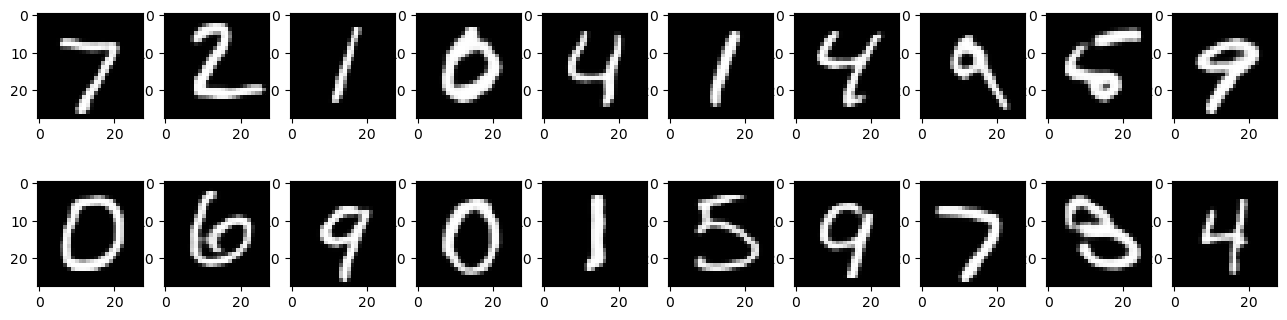

In [26]:
visualize_data(pred, 2, 10)

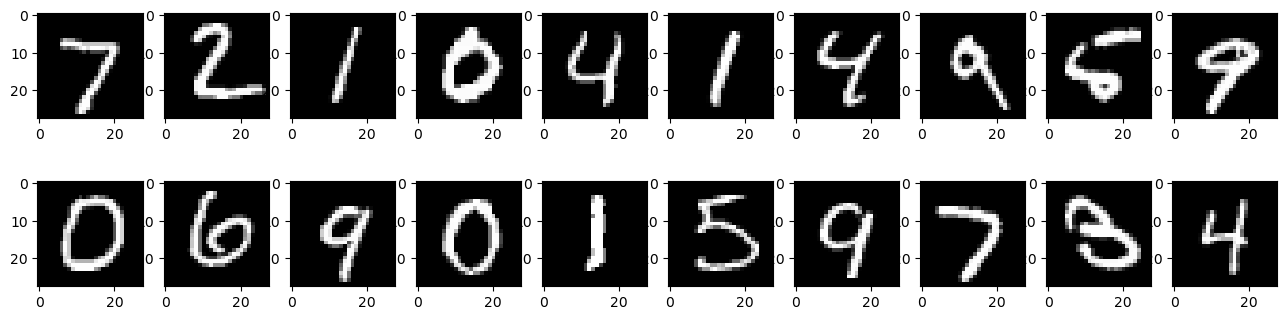

In [27]:
visualize_data(X_test[:20], 2, 10)